## PELS Machine Learning Applications Workshop

This is the solution for a technical test that simulates a real task at Industry.

The assignment involves an FPSO (Floating Production, Storage, and Offloading) vessel, and during the development of the solution I will discuss some insights and conclusions taken from the data.
  
The model is intended to support teams with an equipment failure problem. 


Developed by Marcos Lima.

Email : viniciosgnr@poli.ufrj.br

LinkedIn : https://www.linkedin.com/in/marcos--lima/
<hr>


## Proposed Case

To enable the operations of an FPSO, we use sensors to make sure the equipment does not fail. These sensors measure different parameters of the equipment in different setups configurations (preset 1 and preset 2) over time. We want you to investigate one piece of equipment in different time cycles to understand what characteristics and parameters of the sensors might indicate that the equipment is on the verge of failing. To solve this problem, we expect you to answer a few questions regarding the attached dataset:

 

1 – Calculate how many times the equipment has failed 

2 – Categorize equipment failures by setups configurations (preset 1 and preset 2)

3 – Categorize equipment failures by their nature/root cause according to parameter readings (temperature, pressure, and others)

4 – Create a model using the technique you think is most appropriate and measure its performance

5 – Analyze variable importance
<hr>



<hr>

## Business Context

Predictive maintenance helps to estimate when maintenance should be performed and helps avoiding break down, repair cost, safety risks and unnecessary regular maintenance.

FPSO machine units are exposed to typical bearing failures, water/oil leaks, and electrical faults.

In this case study we will build an end to end **Machine Learning model to predict the machine status given an input** so that allowing the team to react proactively and plan the most appropriate maintenance solution.
<hr>

## 1. Imports and Reading Dataset

First we need to select some well known libraries used in Data Science such as **Seaborn** and **Matplotlib** to visualize the data and **Pandas** to handle our dataset.

After that we may read the excel file given and start some preliminary analysis.
<hr>


In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# pd.read_excel used for reading the dataset
df = pd.read_excel('O&G Equipment Data.xlsx')

# first dataset visualization method
df.head()

Cycle  Preset_1  Preset_2  Temperature    Pressure  VibrationX  VibrationY  \
0      1         3         6    44.235186   47.657254   46.441769   64.820327   
1      2         2         4    60.807234   63.172076   62.005951   80.714431   
2      3         2         1    79.027536   83.032190   82.642110   98.254386   
3      4         2         3    79.716242  100.508634  122.362321  121.363429   
4      5         2         5    39.989054   51.764833   42.514302   61.037910   

   VibrationZ  Frequency   Fail  
0   66.454520  44.483250  False  
1   81.246405  60.228715  False  
2   98.785196  80.993479  False  
3  118.652538  80.315567  False  
4   50.716469  64.245166  False

<hr>

Now we can define column will be our target variable, in this case **Fail** , and the rest being our features
<hr>


In [13]:
#target variable
target = 'Fail'

#defining our features columns
features = list(df.columns)
features.remove(target)
features

['Cycle',
 'Preset_1',
 'Preset_2',
 'Temperature',
 'Pressure',
 'VibrationX',
 'VibrationY',
 'VibrationZ',
 'Frequency']

## 2. Data Description

In [14]:
# Basic characteristics of the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Cycle        800 non-null    int64  
 1   Preset_1     800 non-null    int64  
 2   Preset_2     800 non-null    int64  
 3   Temperature  800 non-null    float64
 4   Pressure     800 non-null    float64
 5   VibrationX   800 non-null    float64
 6   VibrationY   800 non-null    float64
 7   VibrationZ   800 non-null    float64
 8   Frequency    800 non-null    float64
 9   Fail         800 non-null    bool   
dtypes: bool(1), float64(6), int64(3)
memory usage: 57.2 KB


<hr>
With these first methods we can already extract some basic informations about our data. 

- 10 collumns
- 800 rows/Number of observations 
- **No need to handle missing values**
- All feature collumns are numeric
- Target collumn is binary, **True** or **False**


<hr>



We can obtain a statistical review of our data using the 'describe( )' method.
<hr>

<br>

In [15]:
# describes the statistics of our data
df.describe()

Cycle    Preset_1    Preset_2  Temperature    Pressure  VibrationX  \
count  800.0000  800.000000  800.000000   800.000000  800.000000  800.000000   
mean   400.5000    1.988750    4.551250    69.263494   78.997945   73.860275   
std    231.0844    0.805875    2.293239    25.536252   32.501834   31.229631   
min      1.0000    1.000000    1.000000     2.089354    3.480279    3.846343   
25%    200.7500    1.000000    3.000000    51.040134   55.508564   50.752461   
50%    400.5000    2.000000    5.000000    65.906716   75.014848   69.394953   
75%    600.2500    3.000000    7.000000    80.527220   99.302530   90.195059   
max    800.0000    3.000000    8.000000   255.607829  189.995681  230.861142   

       VibrationY  VibrationZ   Frequency  
count  800.000000  800.000000  800.000000  
mean    72.786878   71.866211   68.223449  
std     32.739745   27.844616   29.138702  
min     10.057744   18.784169    4.380101  
25%     48.523982   50.787638   45.861762  
50%     65.504770   69.319237   65.664252  
75%     94.075572   88.891205   90.097457  
max    193.569947  230.951134  178.090303

<hr>
Considering that we are dealing with an engineering problem (Predictive Maintenance) and dealing with machines, there are some assumptions to make:

- This seems to be a time-series dataset where the data is captured from the sensors in cycles.
- Since most of the time our machines are supposed to be working smoothly, we can expect a unbalanced distribution in the **Fail** ocurrences.

<hr>


All the classifiers are developed to solve some business problem so the False Positives and False Negatives are going to have different importances:

- **False Negatives** = It´s the one we need to take care the most, because this means that the machine failed and our model didn´t noticed.
- **False Positives** = It Will demand the maintenance team to act, so costs money to mobilize teams for a fault that not ocurred.
- **True Negatives** = Model classified non-ocurrence that is actually a non-ocurrence.
- **True Positive** = Model classified right in the ocurrence of a fault.

<hr>


### Null
Checking for null values
<hr>

In [16]:
#sum of the null values
df.isnull().sum()

Cycle          0
Preset_1       0
Preset_2       0
Temperature    0
Pressure       0
VibrationX     0
VibrationY     0
VibrationZ     0
Frequency      0
Fail           0
dtype: int64

<hr>

**So no missing values to be filled**
<hr>

### Unique Values

In [17]:
#checking the number of unique values on each column
for i in df.columns:
    print(i,len(df[i].unique()))

Cycle 800
Preset_1 3
Preset_2 8
Temperature 800
Pressure 800
VibrationX 800
VibrationY 800
VibrationZ 800
Frequency 800
Fail 2


<hr>

### Pandas-Profiling

We can take advantage of the *pandas_profiling* to quickly extract some alerts of high correleted variables, distributions and to review our previous steps.

Also we need to convert the **categorical** columns to 'category' in order to the *pandas profilling*  **plot the correct Cramer´s V Correlation Matrix**
<hr>

In [18]:
import pandas_profiling as pp

# For the correct use of Pandas Profilling defining the categorical features as 'category'
df['Preset_1'] = df.Preset_1.astype('category')
df['Preset_2'] = df.Preset_2.astype('category')
df.dtypes

Cycle             int64
Preset_1       category
Preset_2       category
Temperature     float64
Pressure        float64
VibrationX      float64
VibrationY      float64
VibrationZ      float64
Frequency       float64
Fail               bool
dtype: object

In [9]:
df.profile_report(infer_dtypes=False)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<hr>
So in our dataset:

- **Preset_1** and **Preset_2** are categorical values described numerically with no ordinal relation.

- From the **Cramer´s V Correlation Matrix** for categorical features, **Preset_1** and **Preset_2** are not highly correlated to the occurrences of Faults

- **Cycle** is our time variable as it`s uniformly distributed with unique values.

## 3. Data Analysis
### - Feature Selection


<hr>

**Feature Importance** — You can gain the significance of each feature of your dataset by using the Model Characteristics property.

Feature value gives you a score for every function of your results, the higher the score the more significant or appropriate the performance variable is.


<hr>

In [19]:
#Feature Importance
from sklearn.ensemble import ExtraTreesClassifier

#copy of our dataset
data = df.copy()

#independent columns
X = data.loc[:,features]

#target column
y = data.loc[:,target]    


<hr>
Feature importance is the built-in class that comes with Tree Based Classifiers, we will use the Extra Tree Classifier to extract the top features for the dataset.
<hr>

[0.08702018 0.03690143 0.05024175 0.11403805 0.13118267 0.09713378
 0.21385261 0.14114465 0.12848487]


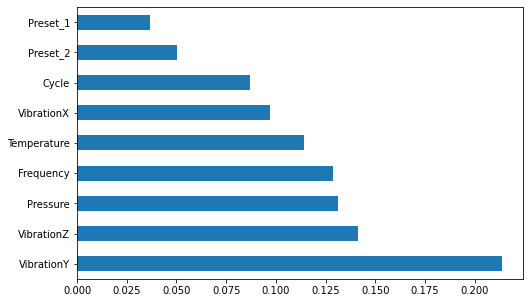

In [20]:
#Tree Based Classifier
model = ExtraTreesClassifier()

#fit the model
model.fit(X,y)

#use inbuilt class feature_importances of tree based classifiers
print(model.feature_importances_)


#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(13).plot(kind='barh',figsize=(8,5))
plt.show()

<hr>

We may notice that the **Presets** are not too importants here, which we will still invastigate during this study.

We could drop the less important features(**Preset_1**, **Preset_2**) in case our model overfits to simplify the features.
<hr>

<hr>

**Univariate Selection** — Statistical tests may be used to pick certain features that have the best relationship to the performance variable.
The scikit-learn library provides the **SelectKBest** class that can be used to select a specific number of features in a suite of different statistical tests.
The following example uses the  ANOVA F value statistical test to select the best features from the Dataset.
<hr>

In [27]:

from sklearn.feature_selection import chi2, f_classif, SelectKBest
 
#apply SelectKBest class to extract top best features
bestfeatures = SelectKBest(score_func=f_classif, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)

featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(9,'Score'))  #print best features

         Specs       Score
6   VibrationY  208.840049
7   VibrationZ  124.883786
4     Pressure  108.167861
8    Frequency   94.428716
3  Temperature   64.094127
5   VibrationX   54.459142
0        Cycle   17.293847
1     Preset_1    1.735445
2     Preset_2    0.220432


<hr>

**Correlation Matrix with Heatmap** — Correlation indicates how the features are related to each other or to the target variable.
The correlation may be positive (increase in one value of the feature increases the value of the target variable) or negative (increase in one value of the feature decreases the value of the target variable)
Heatmap makes it easy to classify the features are most relevant to the target variable, and we will plot the associated features of the heatmap using the seaborn library.
<hr>

[Text(0.5, 1.0, 'Pearson Correlation Matrix')]

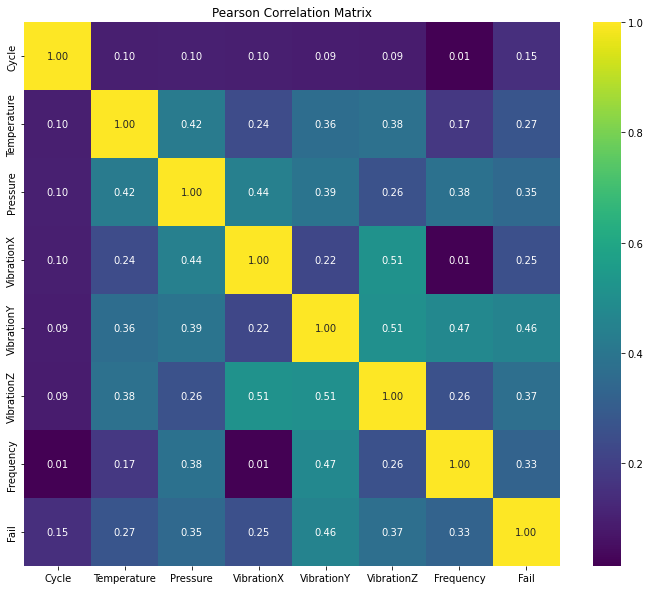

In [25]:
#Correlation Matrix with Heatmap 
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),annot=True,cmap='viridis',fmt='.2f').set(title='Pearson Correlation Matrix')

<hr>

The correlation coefficient is defined in the -1 to 1 range. A value close to 0 means there is no correlation. Value of 1 suggests a perfect positive correlation (e.g. as the **VibrationY** increases, our number of fails increases too!). Value of -1 suggests perfect negative correlation (e.g. high number of bad reviews should correlate with lower prices).
<hr>

In [26]:
#sort the values on the Fail row
df.corr().loc['Fail', :'Frequency'].sort_values()

Cycle          0.145643
VibrationX     0.252754
Temperature    0.272666
Frequency      0.325286
Pressure       0.345497
VibrationZ     0.367857
VibrationY     0.455435
Name: Fail, dtype: float64

<hr>

We can see that again the **VibrationY**, **VibrationZ**, **Pressure** and **Frequency** are the most important features in our dataset and will influence more on taking the machines to a fault condition.

On the first methodology the **Preset_1** and **Preset_2** influenced less than the other features and also from the **Cramer´s V Correlation Matrix** for categorical features, **Preset_1** and **Preset_2** are not highly correlated to the occurrences of Faults.So if our model overfits we can train without theses features to see if our performance increases.
<hr>

<hr>

- **Vibrations(X Y Z)** are highly correlated with each other as expected --> Vibration along one axis moves the other axis

- **Pressure** is highly correlated with **Temperature**  --> Pressure increases then Temperature increases (**Ideal Gas Law** from physics)

- **VibrationX** is highly correlated with **Temperature** --> Temperature increases then VibrationX increases

- **VibrationZ** is highly correlated with **Temperature** --> Temperature increases then VibrationZ increases

- **VibrationY** is highly correlated with **Pressure**   --> Pressure increases then VibrationY increases

- **VibrationY** is highly correlated with  **Frequency** --> Frequency increases then VibrationY increases

- **Fail** is highly correlated with **VibrationY**

**The most important insight here is that the fail is highly correlated with the VibrationY, so VibrationY tends to influence more in the models and take the machines to a Fault condition**.

<hr>

## 4. Data Visualization

<hr>
Let´s first have a look at the outliers, and understand if they are involved in the fail ocurrences.
<hr>


[Text(0.5, 1.0, 'Outliers Investigation'),
 Text(0.5, 0, 'Features'),
 Text(0, 0.5, 'Values')]

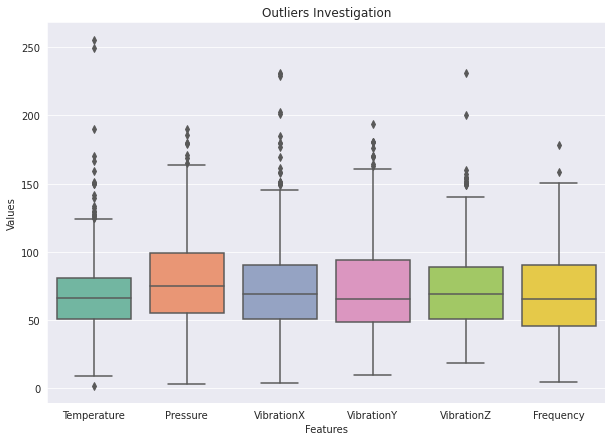

In [766]:
#Setting the style of the plot
sns.set_style('darkgrid')
sns.set_palette('Set2')


#Only the numerical features are involved in this investigation
plt.figure(figsize = (10,7))
numerical_features = ['Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']
sns.boxplot(data = data[numerical_features]).set(title='Outliers Investigation',
                                                 xlabel='Features',
                                                 ylabel='Values')

<hr>

From Statistics we can count the total **upper** and **lower** outliers and the ones involved in the fault ocurrences:
<hr>

In [767]:
# outliers subset
outl = data[numerical_features].copy()

# 0.25 and 0.75 quartiles
q1 = outl.quantile(0.25)
q3 = outl.quantile(0.75)

# interquartile range
iqr = q3 - q1

#upper and lower outliers borders
upper_outlier = q3 + (1.5 * iqr)
lower_outlier = q1 - (1.5 * iqr)


#Total number of outliers

total_outliers = ((outl < lower_outlier) |  (outl > (upper_outlier))).sum()

print('Total Outliers:\n\n', total_outliers)

print('\n-----------------------------------------------------------------------\n')

#upper and lower outliers involoved in the fault ocurrences
for f in numerical_features:
    
    # Sum of upper outliers involved and the porcentage of the total
    upper_outl_involved = np.sum(df[target][outl[f] > upper_outlier[f]])
    upper_porcentage_involved = (upper_outl_involved/total_outliers[f])*100
    print(f"{f}_upper_involved {upper_outl_involved} --> {upper_porcentage_involved}% of the total outliers")
    
    
    # Sum of lower outliers involved and the porcentage of the total
    lower_outl_involved = np.sum(df[target][outl[f] < lower_outlier[f]])
    lower_porcentage_involved = (lower_outl_involved/total_outliers[f])*100
    print(f"{f}_lower_involved: {lower_outl_involved} --> {lower_porcentage_involved} % of the total outliers\n")
    



Total Outliers:

 Temperature    22
Pressure        8
VibrationX     20
VibrationY     10
VibrationZ     14
Frequency       2
dtype: int64

-----------------------------------------------------------------------

Temperature_upper_involved 5 --> 22.727272727272727% of the total outliers
Temperature_lower_involved: 0 --> 0.0 % of the total outliers

Pressure_upper_involved 5 --> 62.5% of the total outliers
Pressure_lower_involved: 0 --> 0.0 % of the total outliers

VibrationX_upper_involved 5 --> 25.0% of the total outliers
VibrationX_lower_involved: 0 --> 0.0 % of the total outliers

VibrationY_upper_involved 6 --> 60.0% of the total outliers
VibrationY_lower_involved: 0 --> 0.0 % of the total outliers

VibrationZ_upper_involved 8 --> 57.14285714285714% of the total outliers
VibrationZ_lower_involved: 0 --> 0.0 % of the total outliers

Frequency_upper_involved 1 --> 50.0% of the total outliers
Frequency_lower_involved: 0 --> 0.0 % of the total outliers



<hr>

**So we can extract that the majority of the upper outliers are involved in the fault ocurrences**.

Therefore we are going to conduct our study **including the outliers of Temperature, Pressure, VibrationX, VibrationY, VibrationZ and Frequency** as they are relevant.

Having the option to train our data dropping **Preset_1** and **Preset_2**  from the dataset to simplify our model and reduce the chances to occur an overfiting.
<hr>

<hr>

## Fail Occurrences
Now we can study how imbalanced is our dataset. **We already expect an imbalanced dataset as engineering machines are project to be robust and last**.

So the occurrences of True labels will be the minority.But no problem, that is the natural distribution of this business problem.
<hr>

In [768]:
#Extract the number of fault occurrences

true_occurrences = data['Fail'][data['Fail']==True].value_counts()
false_occurrences = data['Fail'][data['Fail']==False].value_counts()

print(f"False occurrences:{false_occurrences.values}\nTrue occurrences:{true_occurrences.values}")

#Porcentage of the total occurrences
false_occurrences_percentage = (false_occurrences/len(data))*100
true_occurrences_percentage = (true_occurrences/len(data))*100

print('\n----------------------------\n')
print(f"Didn´t Fail occurrences porcentage: {false_occurrences_percentage.values}%\nFail occurrences porcentage: {true_occurrences_percentage.values}%")

False occurrences:[734]
True occurrences:[66]

----------------------------

Didn´t Fail occurrences porcentage: [91.75]%
Fail occurrences porcentage: [8.25]%


<hr>

So the **Fail** occurrences are less than 10%. Also we can investigate methods to oversampling the minority class or just mantain the natural distributuion of the problem 
<hr>

[Text(0.5, 1.0, 'Data Distribution'),
 Text(0.5, 0, 'Fail'),
 Text(0, 0.5, 'Values')]

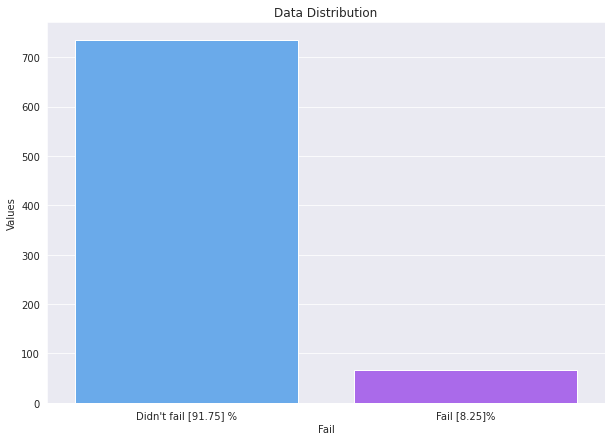

In [769]:
#Plot the bar plot to visualize the distribution
plt.figure(figsize = (10,7))
sns.barplot(x = [f'Didn\'t fail {false_occurrences_percentage.values} %',f'Fail {true_occurrences_percentage.values}%'],
            y = list(data.Fail.value_counts()), palette='cool').set(title='Data Distribution',
                                                                    xlabel='Fail',
                                                                    ylabel='Values')


<hr>

- So we have 800 cycles in which 66(8.25%) fails and 734(91.75%) Don´t.

<hr>


<hr>

## Visualizing
Considering that we have the cycles we can visualize the occurrences of faults in time

We can take advantage of the library *plotly* to have an interactive plot
<hr>


In [770]:
import plotly.graph_objects as go
import plotly.io as pio

#Creating figure and scatter plot
pio.renderers.default = "iframe" 

fig = go.Figure()
fig.add_trace(go.Scatter(x = data.Cycle,
                         y = data.Fail,
                         mode = 'lines',
                         name = 'Test'))

<hr>

From the interactive plot we can notice that the failures come together and **in some blocks recover then fails again**

So if the model keeps predicting **Fail** between very near faults its still good
<hr>

<hr>

## Counting the Duration of Cycles

we will get the **start**  and the **end** of each fail and calculate the **duration**

<hr>

In [771]:
#indixes of each fail
fail_indixes = data['Cycle'][data['Fail']==True].to_list()


#starting the variables
hold = 12
duration = 0
duration_list = []
start_fail = [12]

#iterate to find 
for i in fail_indixes[1:]:
    if i-hold == 1:
        duration += 1
        
    else:
        duration_list.append(duration+1)
        duration = 0
        start_fail.append(i)
    hold = i
    
#get the value left        
duration_list.append(duration+1) 

#list comprehension to calculate the duration
ending = [x + y-1 for x, y in zip(start_fail, duration_list)]

count_fails = pd.DataFrame({
    'Starting cycle': start_fail,
    'Ending cycle': ending,
    'Duration[Cycles]': duration_list
})

count_fails

Starting cycle  Ending cycle  Duration[Cycles]
0              12            12                 1
1             157           159                 3
2             163           165                 3
3             263           265                 3
4             270           271                 2
5             415           432                18
6             538           546                 9
7             550           554                 5
8             700           713                14
9             793           800                 8

<hr>

## Considering that the machine keeps broken between intervals

<hr>

In [772]:
# points between intervals will be set to True
data.at[[159,160,161,162,265,266,267,268,269,546,547,548,549],'Fail'] = True


<hr>

## Visualizing
Considering that we have the cycles we can visualize the occurrences of faults in time

We can take advantage of the library **plotly** to have an interactive plot
<hr>

In [773]:
import plotly.graph_objects as go
import plotly.io as pio

#Creating figure and scatter plot
pio.renderers.default = "iframe" 

fig = go.Figure()
fig.add_trace(go.Scatter(x = data.Cycle,
                         y = data.Fail,
                         mode = 'lines',
                         name = 'Test'))

<hr>

**So we can see that some faults occur very close of each other, so probably the machine recovered and failed again in a short period of time or we can consider that the machine keeps in fail mode**
<hr>

<hr>

## Counting the Duration of Cycles

we will get the **start**  and the **end** of each fail and calculate the **duration**

<hr>

In [774]:
#indixes of each fail
fail_indixes = data['Cycle'][data['Fail']==True].to_list()


#starting the variables
hold = 12
duration = 0
duration_list = []
start_fail = [12]

#iterate to find 
for i in fail_indixes[1:]:
    if i-hold == 1:
        duration += 1
        
    else:
        duration_list.append(duration+1)
        duration = 0
        start_fail.append(i)
    hold = i
    
#get the value left        
duration_list.append(duration+1) 

#list comprehension to calculate the duration
ending = [x + y-1 for x, y in zip(start_fail, duration_list)]

count_fails = pd.DataFrame({
    'Starting cycle': start_fail,
    'Ending cycle': ending,
    'Duration[Cycles]': duration_list
})

count_fails

Starting cycle  Ending cycle  Duration[Cycles]
0              12            12                 1
1             157           165                 9
2             263           271                 9
3             415           432                18
4             538           554                17
5             700           713                14
6             793           800                 8

In [775]:
#Extract the number of fault occurrences

true_occurrences = data['Fail'][data['Fail']==True].value_counts()
false_occurrences = data['Fail'][data['Fail']==False].value_counts()



<hr>

## Mean Time Between Failures

It is a metric very used in Predictive Maintenance problems, and as the name suggests this is the time the machine is expected to work smoothly between failures

**MTBF = total working time / number of faults occurred**

Here we are going to group the near faults, so considering 7 as seen from the graphic

In [776]:
#the near faults were considered as one, so we get 7
fail_groups = len(count_fails)
mtbf = false_occurrences/fail_groups
print(mtbf)


False    103.428571
Name: Fail, dtype: float64


<hr>

**So after 103 cycles from a fault we can expect another fault to come and mobilize the maintenance team**
<hr>

<hr>

## Mean Time To Repair

Another very used metric in Predic Maintenance  is the Mean Time To Repair. With this we can have an idea of the time to repair a machine.

**MTTR = sum of repair duration/number of interventions performed**
<hr>

In [777]:
#MTTR Formula
mttr = (len(data)-false_occurrences)/fail_groups 
print(mttr)

False    10.857143
Name: Fail, dtype: float64


<hr>

**So we can expect a time to repair about 11 cycles or a litle bit more**
<hr>

<hr>


## Creating a new column for expected fails 

<hr>

In [778]:
# add an empty column
data.insert(9,'Expected_fail',False)
data.tail()

Cycle Preset_1 Preset_2  Temperature    Pressure  VibrationX  VibrationY  \
795    796        2        6    50.469522   98.235421  151.585252   99.341380   
796    797        1        4    49.985270  160.433640  110.953010  160.777175   
797    798        1        4    79.777294  110.535405   61.334995  149.577811   
798    799        2        8    79.360314  159.985443   61.762879  169.773831   
799    800        3        1    80.854011  110.543701  121.032227  131.719473   

     VibrationZ   Frequency  Expected_fail  Fail  
795  148.838481   49.841400          False  True  
796  109.917566  110.919290          False  True  
797  129.463843   70.853353          False  True  
798  130.213426   80.113540          False  True  
799   90.331155   71.261717          False  True

In [779]:
next_expected=[x+103 for x in ending if x+103<=800]

next_expected_complete = []
for i in next_expected:
    aux=list(range(i,i+11))
    next_expected_complete.extend(aux)


In [780]:
# points between intervals will be set to True
data.at[next_expected_complete,'Expected_fail'] = True


In [781]:
#Creating figure and scatter plot
pio.renderers.default = "iframe" 

fig = go.Figure()
fig.add_trace(go.Scatter(x = data.Cycle,
                         y = data.Fail,
                         mode = 'lines',
                         name = 'Data from sensors'))
fig.add_trace(go.Scatter(x=data.Cycle,
                         y=data.Expected_fail,
                         mode='markers',
                         name='expected'))

<hr>

## Equipment failures by Setups

**We already know from the first steps that the features Preset_1 and Preset_2 do not have too much influence in the fault occurrences** from the **Correlation Matrix** and **Feature Importance** steps. Although they don´t influence much in the occurrence of faults we are going to carry a study about the combinations that appear in the faults.  
<hr>

In [782]:
#Back to int values to further apply the Target Encoding
data['Preset_1'] = data.Preset_1.astype(int)
data['Preset_2'] = data.Preset_2.astype(int)

Text(0.5, 1.0, 'Preset_1 v/s Count\n')

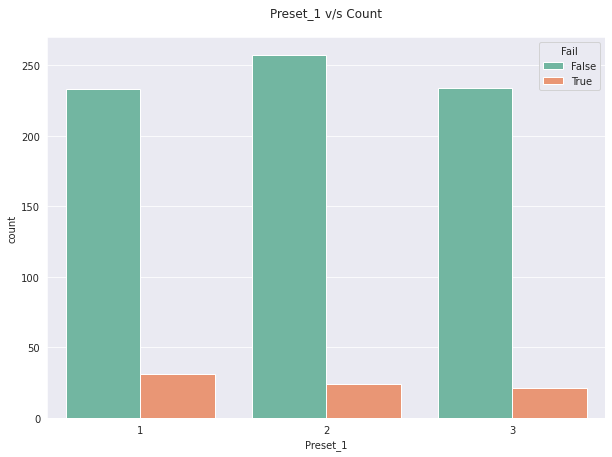

In [783]:
#Preset 1 fault occurrences
plt.figure(figsize=(10,7))
sns.countplot(data= data, x='Preset_1',hue='Fail')
plt.title('Preset_1 v/s Count\n')


Text(0.5, 1.0, 'Preset_2 v/s Count\n')

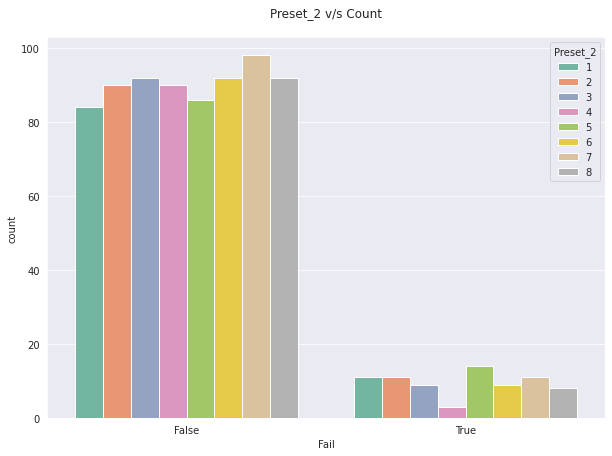

In [784]:
#Preset 2 fault occurrences
plt.figure(figsize=(10,7))
sns.countplot(data= data, x='Fail',hue='Preset_2')
plt.title('Preset_2 v/s Count\n')

<Figure size 720x504 with 0 Axes>

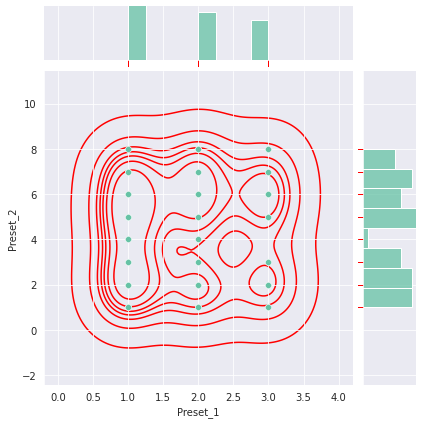

In [785]:
#df['Fail'] == True - fault occurrences
df_fault = data[data['Fail'] == True ][['Preset_1','Preset_2','Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']] 

plt.figure(figsize=(10,7))
g = sns.jointplot(data=df_fault,
                  x='Preset_1',
                  y='Preset_2',
                  )
g.plot_joint(sns.kdeplot, color="r",zorder=0, levels=8)
g.plot_marginals(sns.rugplot, color="r", height=-.1, clip_on=False)

<hr>

From the visualization we can see that the combinations with **Preset_1 = 1** and **Preset_2 = 1 e 5** appear the most in the occurrences of faults
<hr>

## 5. Data Pre-processing

The goal here is to transform the data into a form that is suitable for your model. There are several things you want to do when handling (think CSV,Excel) structured data:

- Handle missing data
- Remove unnecessary columns
- Transform any categorical features to numbers
- Scale numerical features

<hr>

In [786]:
#Listing our collumn names
data.columns

Index(['Cycle', 'Preset_1', 'Preset_2', 'Temperature', 'Pressure',
       'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency', 'Expected_fail',
       'Fail'],
      dtype='object')

<hr>

### Label Encoder
In our target collumn whe have words (True and false), so we need **Label encoder** to convert to numbers (0 and 1) 

<hr>


In [787]:
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder

data[target]

0      False
1      False
2      False
3      False
4      False
       ...  
795     True
796     True
797     True
798     True
799     True
Name: Fail, Length: 800, dtype: bool

In [788]:
#Label encoder instance and transformation of target collumn
le = LabelEncoder()
data['Fail'] = le.fit_transform(data.Fail)
data['Expected_fail'] = le.fit_transform(data.Expected_fail)

In [789]:
data.head()

Cycle  Preset_1  Preset_2  Temperature    Pressure  VibrationX  VibrationY  \
0      1         3         6    44.235186   47.657254   46.441769   64.820327   
1      2         2         4    60.807234   63.172076   62.005951   80.714431   
2      3         2         1    79.027536   83.032190   82.642110   98.254386   
3      4         2         3    79.716242  100.508634  122.362321  121.363429   
4      5         2         5    39.989054   51.764833   42.514302   61.037910   

   VibrationZ  Frequency  Expected_fail  Fail  
0   66.454520  44.483250              0     0  
1   81.246405  60.228715              0     0  
2   98.785196  80.993479              0     0  
3  118.652538  80.315567              0     0  
4   50.716469  64.245166              0     0

<hr>

### Gather columns
Using all the features provided
<hr>

In [790]:
#Selection of the features used
features = ['Cycle','Preset_1','Preset_2','Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency','Expected_fail']
category_cols = ['Preset_1','Preset_2']
#['Cycle','Preset_1','Preset_2','Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency', 'Expected_fail']



#independent columns
X = data.loc[:,features]
#target column 
y = data.loc[:,target]    



<hr>

### Splitting Data

We are going to use the train test split with test size of 20% of the total dataset

Here we need to set **shuffle to False** since we are working with a **Time Series**

<hr>

In [791]:
from sklearn.model_selection import train_test_split

# Import train_test_split function
# 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0,
                                                    shuffle=False) 
X_train

Cycle  Preset_1  Preset_2  Temperature    Pressure  VibrationX  \
0        1         3         6    44.235186   47.657254   46.441769   
1        2         2         4    60.807234   63.172076   62.005951   
2        3         2         1    79.027536   83.032190   82.642110   
3        4         2         3    79.716242  100.508634  122.362321   
4        5         2         5    39.989054   51.764833   42.514302   
..     ...       ...       ...          ...         ...         ...   
635    636         1         6    44.089549   28.183491   51.221942   
636    637         2         7    60.160708   44.476705   69.355771   
637    638         2         2    70.318580   55.083011   97.287283   
638    639         3         1    45.651266   28.815787   40.275921   
639    640         3         8    66.240932   39.372597   52.230825   

     VibrationY  VibrationZ  Frequency  Expected_fail  
0     64.820327   66.454520  44.483250              0  
1     80.714431   81.246405  60.228715              0  
2     98.254386   98.785196  80.993479              0  
3    121.363429  118.652538  80.315567              0  
4     61.037910   50.716469  64.245166              0  
..          ...         ...        ...            ...  
635   55.415820   63.556314  45.088796              0  
636   72.792957   84.581131  54.665615              0  
637   95.125888  109.439529  66.639939              0  
638  105.113802   48.642734  19.153493              0  
639  124.600211   59.612713  30.481700              0  

[640 rows x 10 columns]

<hr>

### Mean Encoder/Target Encoder
If we decide to include in the training the **Presets** we will perform a *mean encoder* on these collumns

From a mathematical point of view, mean encoding represents a probability of your target variable, conditional on each value of the feature. In a way, it embodies the target variable in its encoded value.
<hr>

In [792]:
# doing the mean encoder in the Trainning Dataset
'''
import category_encoders as ce


#Create target encoding object
encoder=ce.TargetEncoder(cols=['Preset_1','Preset_2']) 

#Fit 
encoder.fit(X_train[['Preset_1','Preset_2']], y_train)

#Transform
X_train[['Preset_1','Preset_2']] = encoder.transform(X_train[['Preset_1','Preset_2']])
X_test[['Preset_1','Preset_2']] = encoder.transform(X_test[['Preset_1','Preset_2']])
'''

"\nimport category_encoders as ce\n\n\n#Create target encoding object\nencoder=ce.TargetEncoder(cols=['Preset_1','Preset_2']) \n\n#Fit \nencoder.fit(X_train[['Preset_1','Preset_2']], y_train)\n\n#Transform\nX_train[['Preset_1','Preset_2']] = encoder.transform(X_train[['Preset_1','Preset_2']])\nX_test[['Preset_1','Preset_2']] = encoder.transform(X_test[['Preset_1','Preset_2']])\n"

In [793]:
X_test

Cycle  Preset_1  Preset_2  Temperature    Pressure  VibrationX  \
640    641         1         7   109.623640   65.900820   74.272427   
641    642         3         2    62.055870   42.443418   49.695370   
642    643         2         1    75.051980   85.485302   62.097861   
643    644         1         6    35.507117   48.561646   49.632195   
644    645         3         1    52.620575   63.643075   63.880568   
..     ...       ...       ...          ...         ...         ...   
795    796         2         6    50.469522   98.235421  151.585252   
796    797         1         4    49.985270  160.433640  110.953010   
797    798         1         4    79.777294  110.535405   61.334995   
798    799         2         8    79.360314  159.985443   61.762879   
799    800         3         1    80.854011  110.543701  121.032227   

     VibrationY  VibrationZ   Frequency  Expected_fail  
640  122.768567   85.199467   29.911242              0  
641   45.094147   50.909119   54.786997              0  
642   88.083041   62.178966   98.541017              0  
643   65.033180   60.525825   43.500363              0  
644   79.211967   74.305128   57.901718              0  
..          ...         ...         ...            ...  
795   99.341380  148.838481   49.841400              0  
796  160.777175  109.917566  110.919290              0  
797  149.577811  129.463843   70.853353              0  
798  169.773831  130.213426   80.113540              0  
799  131.719473   90.331155   71.261717              0  

[160 rows x 10 columns]

<hr>

### Normalization

To avoid data leak we are going to apply a **MinMax Scaler** since this takes into account the outlliers that we saw are important to our model to classify well the Fail occurrences 


We can then define the MinMaxScaler and call the fit() function on the training set, then apply the transform() function on the train and test sets to create a normalized version of each dataset.


This avoids **data leakage** as the calculation of the minimum and maximum value for each input variable is calculated using only the training dataset (X_train) instead of the entire dataset (X).
<hr>

In [794]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
'''

# build the scaler model
scaler = MinMaxScaler()



# fit on the training dataset
scaler.fit(X_train)


# scale the training dataset
X_train[features] = scaler.transform(X_train[features])
# scale the test dataset
X_test[features] = scaler.transform(X_test[features])

X_test
'''

'\n\n# build the scaler model\nscaler = MinMaxScaler()\n\n\n\n# fit on the training dataset\nscaler.fit(X_train)\n\n\n# scale the training dataset\nX_train[features] = scaler.transform(X_train[features])\n# scale the test dataset\nX_test[features] = scaler.transform(X_test[features])\n\nX_test\n'

<hr>

### SMOTE - Synthetic Minority Oversampling Technique

Smote is a oversampling method and was tested to **generate synthetic minority** class ocurrences, but with no sucess since the data is a a time series.

**Thus is better to mantain the natural distribution of our problem**
<hr>

In [795]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids

#cc = ClusterCentroids(random_state=0,sampling_strategy=0.9)
#smote = SMOTE(random_state=0,sampling_strategy=0.07)


#X_train, y_train= smote.fit_resample(X_train, y_train)


<hr>

### Weighted model for Class Imbalance

In cases of Class Imbalance in time series a option to consider is to make weighing of the balance of positive examples, relative to negative examples when boosting decision trees

As such, the scale_pos_weight can be used to train a class-weighted or cost-sensitive version of XGBoost for imbalanced classification.

<hr>

In [796]:
train_true_occurrences = y_train[y_train==True].value_counts()
train_false_occurrences = y_train[y_train==False].value_counts()


train_false_occurrences = float(train_false_occurrences)
train_true_occurrences = float(train_true_occurrences)


print(train_false_occurrences,train_true_occurrences)
#scale_pos_weight to set on tree based models
train_scale_pos_weight = train_false_occurrences/train_true_occurrences
print(f'train_scale_pos_weight:   {train_scale_pos_weight}')

586.0 54.0
train_scale_pos_weight:   10.851851851851851


<hr>

## Machine Learning Models
**This is a Supervised Machine Learning problem**

We have the the challenge to classify **True or False**, so we are going to use **binary classifiers**.

I have picked some that are suitable for the problem.I tried to select models from different categories

- Logistic Regression
- Support Vector Machines - SVM
- Random Forest
- CatBoost
- XGBoost Classifier


We will compare these models using some metrics: 

- Accuracy
- Precision
- Recall
- Score F1
- Confusion matrix

These metrics are the most used in Machine Learning problems.In this specific problem we need to take care of the **False Negatives** because costs more money to not classify correctly an occurrence of Fault.

**So we will focus on the Recall and Score F1 since they take into account the influence of the recall and false negatives**

**Remembering that our minority class is the most important here**

<hr>

### 4. Fitting into Model

In [797]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# XGboost
import xgboost as xgb


# CatBoost
from catboost import CatBoostClassifier


# Metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [798]:
models = {}

#Our Five models chosen
models['Decision Tree'] = DecisionTreeClassifier(random_state=0,
                                                 class_weight='balanced'
                                                )
                                                     

models['Random Forest'] = RandomForestClassifier(random_state=0,
                                                 class_weight='balanced'
                                                )
                                                 

models['CatBoost'] = CatBoostClassifier(random_state=0,
                                        verbose=0,
                                        scale_pos_weight=train_scale_pos_weight)
'''
Gradient boosting involves the creation and addition of decision trees sequentially,
each attempting to correct the mistakes of the learners that came before it.
'''
models['XgBoost'] = xgb.XGBClassifier(random_state=0,
                                      objective= 'binary:logistic',
                                      use_label_encoder=False,
                                      scale_pos_weight=train_scale_pos_weight
                                     )



In [799]:
accuracy, precision, recall, f1score, fn = {}, {}, {}, {}, {}

for key in models.keys():
    
    
    # fit the classifier model in the dictionary
    models[key].fit(X_train, y_train.values.ravel())

    
    # prediction 
    predictions = models[key].predict(X_test)

    TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()
    print(key,'\n',classification_report(y_test, predictions),'\n\n\n')
    
    # calculate metrics
    accuracy[key] = accuracy_score( y_test, predictions)
    precision[key] = precision_score(y_test, predictions)
    recall[key] = recall_score( y_test, predictions)
    f1score[key] = f1_score( y_test, predictions)
    fn[key] = FN

df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()
df_model['F1-Score'] = f1score.values()
df_model['FN'] = fn.values()


df_model

Decision Tree 
               precision    recall  f1-score   support

           0       0.92      0.95      0.94       138
           1       0.61      0.50      0.55        22

    accuracy                           0.89       160
   macro avg       0.77      0.72      0.74       160
weighted avg       0.88      0.89      0.88       160
 



Random Forest 
               precision    recall  f1-score   support

           0       0.89      0.99      0.94       138
           1       0.83      0.23      0.36        22

    accuracy                           0.89       160
   macro avg       0.86      0.61      0.65       160
weighted avg       0.88      0.89      0.86       160
 



CatBoost 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       138
           1       0.77      0.77      0.77        22

    accuracy                           0.94       160
   macro avg       0.87      0.87      0.87       160
weighted avg       0.94

Accuracy  Precision    Recall  F1-Score  FN
Decision Tree    0.8875   0.611111  0.500000  0.550000  11
Random Forest    0.8875   0.833333  0.227273  0.357143  17
CatBoost         0.9375   0.772727  0.772727  0.772727   5
XgBoost          0.9125   0.722222  0.590909  0.650000   9

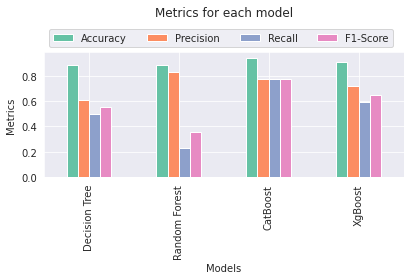

In [800]:
#Visualize the metrics by model
ax  = df_model[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot.bar(rot=90)
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 10})
plt.title('Metrics for each model\n\n')
plt.ylabel('Metrics ')
plt.xlabel('Models')

plt.tight_layout()

<hr>

From the analysis we will keep with the **XGBoost** model with the best **macro F1**, **Accuracy** and number of **False Negatives** compared to the other models

Next we will visualize the number of false negatives

<hr>

Text(0, 0.5, 'False Negatives')

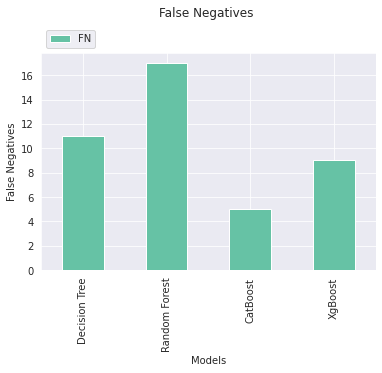

In [801]:
#Visualizing the number of False Negatives
ax  = df_model[['FN']].plot.bar(rot=90)
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 10})
plt.title('False Negatives \n\n')
plt.xlabel('Models')
plt.ylabel('False Negatives')


<hr>

## Predict

Now we can make predictions with the chosen model
<hr>

In [802]:
model = models['XgBoost']
model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_test)

[23:13:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<hr>

**Confusion Matrix** helps us to visualize model performance. It gives count of correctly classified points and misclassified points for each classes.
<hr>

<AxesSubplot:>

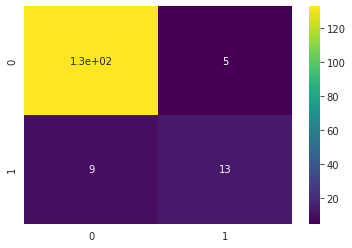

In [803]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap='viridis')

<hr>

### Interactive Plot


<hr>

In [804]:
actual = []
predcition = []
for i,j in zip(y_test,y_pred):
  actual.append(i)
  predcition.append(j)
dic = {'Actual':actual,
       'Prediction':predcition
       }
result  = pd.DataFrame(dic)


In [805]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "iframe" 
fig = go.Figure()

 
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_test,
                    mode='markers+lines',
                    name='Test'))
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_pred,
                    mode='markers',
                    name='Pred'))

<hr>

## Cross Validation and XGBoost Hyperparameter 

In the case of time series, the cross-validation is not trivial. We cannot choose random samples and assign them to either the test set or the train set because it makes no sense to use the values from the future to forecast values in the past. 

Start with a small subset of data for training purpose, forecast for the later data points and then checking the accuracy for the forecasted data points. The same forecasted data points are then included as part of the next training dataset and subsequent data points are forecasted.

Provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets. In each split, test indices must be higher than before, and thus shuffling in cross validator is inappropriate.

This cross-validation object is a variation of KFold. In the kth split, it returns first k folds as train set and the (k+1)th fold as test set.

Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them.
![title](img.png)
<hr>

## XGBoost GridSearh

With the GridSearch we can look for the best combinations of parameters of the chosen model, dividing our Cross Validation with 5 splits

**In the GridSearch our scoring is f1_macro as we need to take care of the minority class**
<hr>

In [806]:

from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import GridSearchCV

#Times series split scheme
folds = TimeSeriesSplit(n_splits=5)


# XGBoost model classifier
xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                            use_label_encoder=False,
                            nthread=64,
                            learning_rate=0.05, 
                            n_estimators=200,
                            gamma=0,
                            colsample_bytree= 0.6,
                            subsample= 0.8,
                            scale_pos_weight=train_scale_pos_weight,
                            max_depth=4,
                            min_child_weight= 5,
                            reg_alpha=1e-05
                            )


    

# parameter to tune

# n_estimators: number of estimators. 
# max_depth: maximum depth of the tree

#setting grid of selected parameters for iteration
param_grid ={'n_estimators':[50,100,150,200,250,300,500,600,800,1000]
             
              }



    
'''
 {'n_estimators':[50,100,150,200,250,300,500,600,800,1000],
              'learning_rate':[0.001,0.005,0.01,0.05,0.1] 
'max_depth':[3,4,5,6,7,8,9,10],
              'min_child_weight':[1,2,3,4,5,6]
'n_estimators':[50,100,150,300,500,600,800,1000]
'max_depth':[3,4,5,6,7],
              'n_estimators': [50,75,100,125,150,300,500,1000],
              'min_child_weight':[1,2,3,4,5,6,7],
             'learning_rate':[0.01,0.05,0.1, 0.3, 0.5]   
             '''
# defining model to tune hyperparameter
xgboost_cv = GridSearchCV(estimator=xgb_clf,
                        param_grid=param_grid,
                        cv=folds,
                        scoring='f1_macro',
                        n_jobs=-1,
                        return_train_score=True,
                        verbose = False)

xgboost_cv.fit(X_train, y_train, verbose = False)



[23:15:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.6,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.05, max_delta_step=None,
                                     max_depth=4,...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=1e-05,
                                     reg_lambda=None,
                                     scale_pos_weight=10.851851851851851,
                                     subsam

In [807]:
# to take a look of the best parameters chosen
xgboost_cv.best_params_

{'n_estimators': 200}

In [808]:
#the instance of our best model from gridsearch
best_grid =xgboost_cv.best_estimator_
best_grid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=64, nthread=64, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=1e-05, reg_lambda=1,
              scale_pos_weight=10.851851851851851, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

<hr>

## Classification Report
<hr>

In [809]:
#our predicions
y_pred = best_grid.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.96      0.98       138
           1       0.81      0.95      0.88        22

    accuracy                           0.96       160
   macro avg       0.90      0.96      0.93       160
weighted avg       0.97      0.96      0.96       160



<hr>

## Confusion Matrix
---
<hr>

<AxesSubplot:>

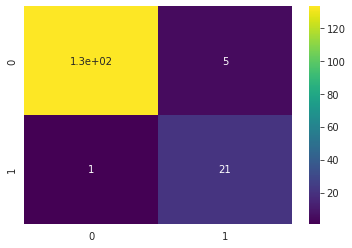

In [810]:
#Confusion matrix
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap='viridis')

<hr>

## ROC Curve and Roc_Auc_Score
**ROC_auc_score = 0.96**

ROC Curves and ROC AUC can be **optimistic on severely imbalanced classification problems** with few samples of the minority class

<hr>

Random Forest: ROC_auc = 0.95916


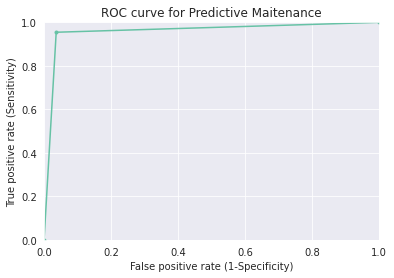

In [811]:
from sklearn.metrics import roc_curve,roc_auc_score, precision_recall_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, marker='.')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Predictive Maitenance')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)



from sklearn.metrics import average_precision_score


# summarize scores
roc_auc = roc_auc_score(y_test,y_pred)
print('Random Forest: ROC_auc = %.5f' % (roc_auc))


<hr>

## Precision Recall Curve
 The Precision-Recall Plot is more informative than the ROC Plot when evaluating binary classifiers on Imbalanced Datasets.
 
- ROC curves should be used when there are roughly equal numbers of observations for each class.
- Precision-Recall curves should be used when there is a moderate to large class imbalance.

The reason for this recommendation is that ROC curves present an optimistic picture of the model on datasets with a class imbalance.

<hr>

Random Forest: f1=0.87500 
               AUC=0.88424


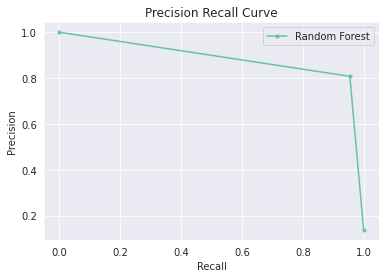

In [812]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# calculate F1 score
f1 = f1_score(y_test, y_pred)

# calculate precision-recall AUC
auc_PRcurve = auc(recall, precision)

# summarize scores
print('Random Forest: f1=%.5f \n               AUC=%.5f' % (f1, auc_PRcurve))


plt.plot(recall, precision, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
# show the legend
plt.legend()
# show the plot
plt.show()

<hr>

## Interactive Visualization
<hr>

In [813]:
actual = []
predcition = []
for i,j in zip(y_test,y_pred):
  actual.append(i)
  predcition.append(j)
dic = {'Actual':actual,
       'Prediction':predcition
       }
result  = pd.DataFrame(dic)


import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "iframe" 
fig = go.Figure()

 
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_test,
                    mode='markers+lines',
                    name='Test'))
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_pred,
                    mode='markers',
                    name='Pred'))

<hr>

# ML EXPLAINABILITY:
- ## SHAP (SHapley Additive exPlanations)

Time to explain how the features influences the decisions inside our model using SHAP
<hr>

In [814]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(best_grid)
shap_values = explainer(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<hr>

 - ## Global Predictions Features Summary:
 To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). 
 
<hr>

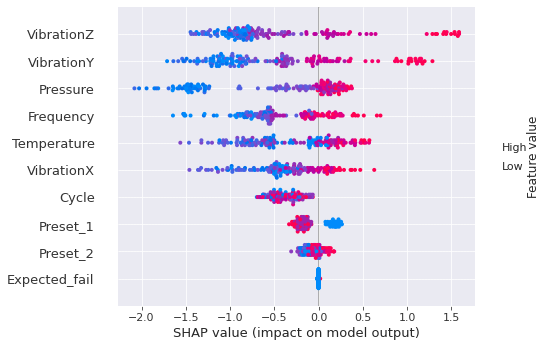

[23:14:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [816]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

 
<hr>

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs):

 
<hr>

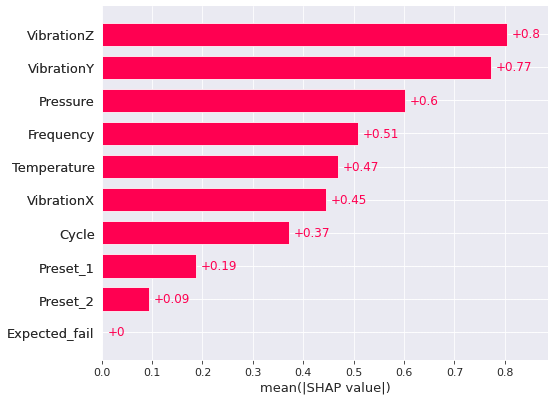

[23:14:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [817]:
shap.plots.bar(shap_values)

<hr>

As we have already stated on the first steps that the **higher values** of **Vibrations on axis Z and Y and also the frequency** have a big influence on the decisions taken in our model

**Also we see that the presets Don´t have a big impact on the predictions**
<hr>

<hr>

 - ## Local Predictions:
 
<hr>

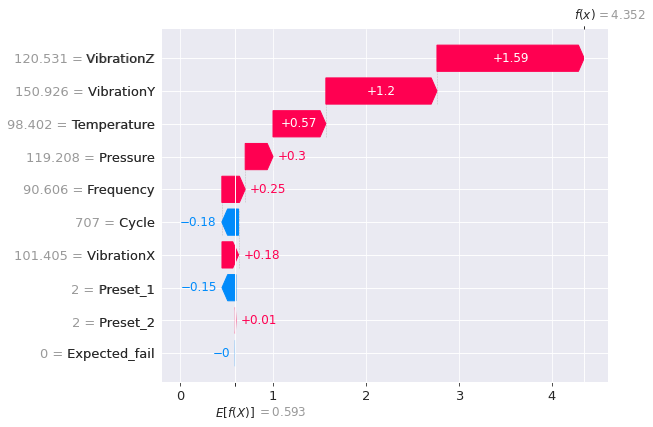

In [818]:
# visualize the 61º prediction's explanation
shap.plots.waterfall(shap_values[66])

<hr>
The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

<hr>

In [819]:
# visualize the 61º prediction's explanation with a force plot
shap.plots.force(shap_values[66])

<hr>

**As we see again Vibration Z and Frequency are very important in this local prediction**.
<hr>

<hr>
If we take many force plot explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (in the notebook this plot is interactive):
<hr>

In [820]:
# visualize all the training set predictions
shap.plots.force(shap_values)

<hr>

## Conclusion

<hr>

We concluded our analysis of the data and with a XGBoost with the gridsearch model to predict failure. We also got a lot insights from the data and used on our favor to get the best results

**The model has an accuracy of 0.96 and a ROC_auc_score of 0.96 and Macro F1-Score of 0.85 which is satisfactory .**

For further studies we can:
- Deploy the model with Flask which is simple and Pythonic
- look for methods to artificially generate more data of the minority class for time series datasets as the SMOTE in not a good approach
- Implement LSTM which could be good for this time series data or a simpler Artificial Neural Network

Also considering the business problem and features involved such as **Pressure, Temperature, Frequency and Vibrations**, we can guess that the machine in question is a Flux Machine such as a **pump or a compressor** 

<hr>

# Extra Experiments
<hr>

<hr>

## Cross Validation and Catboost Hyperparameter 

<hr>

<hr>

### Gather columns
Using all the non categorical features provided in order to simplify our model, improve generalization in new unseen data and avoid overfitting.
<hr>

In [821]:
#Selection of the features used
features = ['Cycle','Preset_1','Preset_2','Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency','Expected_fail']
numerical_features=['Cycle','Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']
cat_features = ['Preset_1','Preset_2',]
#['Cycle','Preset_1','Preset_2','Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']

#independent columns
X = data.loc[:,features]
#target column 
y = data.loc[:,target]   


In [822]:
# For the correct use of Pandas Profilling defining the categorical features as 'category'
X['Preset_1'] = df.Preset_1.astype('category')
X['Preset_2'] = df.Preset_2.astype('category')

X.dtypes

Cycle               int64
Preset_1         category
Preset_2         category
Temperature       float64
Pressure          float64
VibrationX        float64
VibrationY        float64
VibrationZ        float64
Frequency         float64
Expected_fail       int64
dtype: object

<hr>

### Splitting Data

We are going to use the train test split with test size of 20% of the total dataset

Here we need to set shuffle to False since we are working with a time series

<hr>

In [823]:
from sklearn.model_selection import train_test_split

# Import train_test_split function
# 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0,
                                                    shuffle=False) 


<hr>

### Normalization

To avoid data leak we are going to apply a **MinMax Scaler** since this takes into account the outlliers that we saw are important to our model to classify well the Fail occurrences 
<hr>

In [824]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
'''
# build the scaler model
scaler = MinMaxScaler()



# fit on the training dataset
scaler.fit(X_train[numerical_features])


# scale the training dataset
X_train[numerical_features] = scaler.transform(X_train[numerical_features])
# scale the test dataset
X_test[numerical_features] = scaler.transform(X_test[numerical_features])


'''
X_test

Cycle Preset_1 Preset_2  Temperature    Pressure  VibrationX  VibrationY  \
640    641        1        7   109.623640   65.900820   74.272427  122.768567   
641    642        3        2    62.055870   42.443418   49.695370   45.094147   
642    643        2        1    75.051980   85.485302   62.097861   88.083041   
643    644        1        6    35.507117   48.561646   49.632195   65.033180   
644    645        3        1    52.620575   63.643075   63.880568   79.211967   
..     ...      ...      ...          ...         ...         ...         ...   
795    796        2        6    50.469522   98.235421  151.585252   99.341380   
796    797        1        4    49.985270  160.433640  110.953010  160.777175   
797    798        1        4    79.777294  110.535405   61.334995  149.577811   
798    799        2        8    79.360314  159.985443   61.762879  169.773831   
799    800        3        1    80.854011  110.543701  121.032227  131.719473   

     VibrationZ   Frequency  Expected_fail  
640   85.199467   29.911242              0  
641   50.909119   54.786997              0  
642   62.178966   98.541017              0  
643   60.525825   43.500363              0  
644   74.305128   57.901718              0  
..          ...         ...            ...  
795  148.838481   49.841400              0  
796  109.917566  110.919290              0  
797  129.463843   70.853353              0  
798  130.213426   80.113540              0  
799   90.331155   71.261717              0  

[160 rows x 10 columns]

In [825]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

folds = TimeSeriesSplit(n_splits=5)

# CAtBoost model
catboost_clf =  CatBoostClassifier(random_state=0,
                                   verbose=0,
                                   cat_features=cat_features,
                                   early_stopping_rounds=10,
                                   loss_function = 'Logloss',
                                   thread_count = 8,
                                   scale_pos_weight = train_scale_pos_weight,
                                   learning_rate=0.001
                                  )


params = {'learning_rate':[0.03,0.001,0.005,0.01,0.1,0.2,0.3]
          } 
          
'''
'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[25,50,250,100,150,500,1000],
'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200],
          
 '''

"\n'depth':[3,1,2,6,4,5,7,8,9,10],\n          'iterations':[25,50,250,100,150,500,1000],\n'depth':[3,1,2,6,4,5,7,8,9,10],\n          'iterations':[250,100,500,1000],\n          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], \n          'l2_leaf_reg':[3,1,5,10,100],\n          'border_count':[32,5,10,20,50,100,200],\n          \n "

In [826]:
# defining model to tune hyperparameter
catboost_cv = GridSearchCV(estimator = catboost_clf,
                        param_grid=params,
                        cv=folds,
                        scoring='f1_macro',
                        n_jobs=-1,
                        return_train_score=True)

catboost_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostClassifier object at 0x7efb7b382a60>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.03, 0.001, 0.005, 0.01, 0.1, 0.2,
                                           0.3]},
             return_train_score=True, scoring='f1_macro')

In [827]:
# to take a look of the best parameters chosen
catboost_cv.best_params_

{'learning_rate': 0.001}

In [828]:
#the instance of our best model from gridsearch
best_grid = catboost_cv.best_estimator_

<hr>

## Classification Report
<hr>

In [829]:
#our predicions
y_pred = best_grid.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.93      0.97       138
           1       0.71      1.00      0.83        22

    accuracy                           0.94       160
   macro avg       0.85      0.97      0.90       160
weighted avg       0.96      0.94      0.95       160



<hr>

## Confusion Matrix

<hr>

<AxesSubplot:>

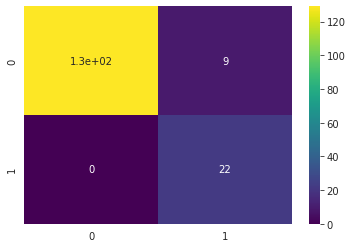

In [830]:
#Confusion matrix
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap='viridis')

<hr>

## ROC Curve
<hr>

Random Forest: ROC_auc = 0.96739


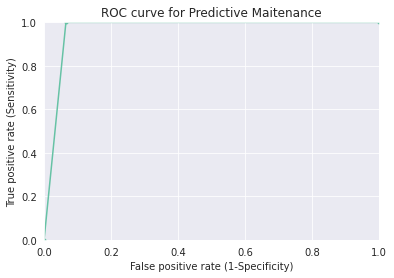

In [831]:
from sklearn.metrics import roc_curve,roc_auc_score, precision_recall_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, marker='.')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Predictive Maitenance')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)



from sklearn.metrics import average_precision_score


# summarize scores
roc_auc = roc_auc_score(y_test,y_pred)
print('Random Forest: ROC_auc = %.5f' % (roc_auc))


<hr>

## Precision-Recall Curve
<hr>

Catboost: f1=0.83019 
           auc=0.85484


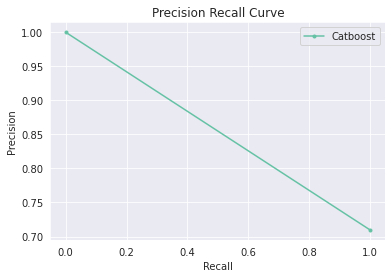

In [832]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# calculate F1 score
f1 = f1_score(y_test, y_pred)

# calculate precision-recall AUC
auc_PRcurve = auc(recall, precision)

# summarize scores
print('Catboost: f1=%.5f \n           auc=%.5f' % (f1, auc_PRcurve))


plt.plot(recall, precision, marker='.', label='Catboost')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
# show the legend
plt.legend()
# show the plot
plt.show()

<hr>

## Interactive Visualization
<hr>

In [833]:
actual = []
predcition = []
for i,j in zip(y_test,y_pred):
  actual.append(i)
  predcition.append(j)
dic = {'Actual':actual,
       'Prediction':predcition
       }
result  = pd.DataFrame(dic)


import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "iframe" 
fig = go.Figure()

 
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_test,
                    mode='markers+lines',
                    name='Test'))
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_pred,
                    mode='markers',
                    name='Pred'))

<hr>

# Deep Learning Approach with Keras Framework

Cross-validation in Deep Learning (DL) might be a little tricky because most of the CV techniques require training the model at least a couple of times. 

In deep learning, we would normally tempt to avoid CV because of the cost associated with training k different models. Instead of doing k-Fold or other CV techniques, you might use a random subset of your training data as a hold-out for validation purposes.

For example, Keras the deep learning library we use allows us to pass one of two parameters for the fit function that performs training.

- **validation_split**: percentage of the data that should be held out for validation
- **validation_data**: a tuple of (X, y) which should be used for validation. This parameter overrides the validation_split parameter which means we can use only one of these parameters at once.

The same approach is used in official tutorials of other DL frameworks such as PyTorch and MxNet. They also suggest splitting the dataset into three parts: training, validation, and testing.

- **Training** – a part of the dataset to train on
- **Validation** – a part of the dataset to validate on while training
- **Testing** – a part of the dataset for final validation of the model


<hr>

<hr>

### Gather columns
Using all the non categorical features provided in order to simplify our model, improve generalization in new unseen data and avoid overfitting.
<hr>

In [920]:
#Selection of the features used
features = ['Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']
category_cols = ['Preset_1','Preset_2']
#['Cycle','Preset_1','Preset_2','Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency', 'Expected_fail']

#independent columns
X = data.loc[:,features]
#target column 
y = data.loc[:,target]    



<hr>

### Splitting Data

We are going to use the train test split with test size of 20% of the total dataset

Here we need to set shuffle to False since we are working with a time series

<hr>

In [921]:
from sklearn.model_selection import train_test_split

# Import train_test_split function
# 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0,
                                                    shuffle=False) 


<hr>

### Normalization

To avoid data leak we are going to apply a **MinMax Scaler** since this takes into account the outlliers that we saw are important to our model to classify well the Fail occurrences 
<hr>

In [922]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

# build the scaler model
scaler = MinMaxScaler()



# fit on the training dataset
scaler.fit(X_train[features])


# scale the training dataset
X_train[features] = scaler.transform(X_train[features])
# scale the test dataset
X_test[features] = scaler.transform(X_test[features])

X_test

Temperature  Pressure  VibrationX  VibrationY  VibrationZ  Frequency
640     0.424167  0.334667    0.310227    0.614187    0.313033   0.146975
641     0.236537  0.208900    0.201965    0.190921    0.151414   0.290178
642     0.287800  0.439669    0.256598    0.425178    0.204531   0.542057
643     0.131816  0.241703    0.201687    0.299574    0.196740   0.225204
644     0.199320  0.322562    0.264451    0.376837    0.261685   0.308109
..           ...       ...         ...         ...         ...        ...
795     0.190835  0.508029    0.650790    0.486527    0.612981   0.261708
796     0.188925  0.841503    0.471805    0.821305    0.429536   0.613316
797     0.306439  0.573975    0.253237    0.760277    0.521663   0.382668
798     0.304794  0.839100    0.255122    0.870330    0.525196   0.435976
799     0.310686  0.574019    0.516204    0.662963    0.337220   0.385018

[160 rows x 6 columns]

<hr>

## Keras Neural Network

Keras is the official high-level API for TensorFlow. In short, it allows us to build complex models using a friendly interface.
<hr>

In [923]:
#Imports
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

BATCH_SIZE = 32

<hr>

- ### Defining the model
The sequential Class allows us to add various layers to your model, easily. Note that we specify the input_size in the first layer using the training data. We also do regularization using **Dropout** layers.

<hr>

In [933]:
# define the neural network model
model = Sequential()

# define first hidden layer and visible layer
model.add(Dense(64,
                input_dim=X_train.shape[1],
                activation='relu')
         )
model.add(Dropout(rate=0.3))

# define second hidden layer 
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.5))

# define output layer
model.add(Dense(1, activation='sigmoid'))

<hr>

- ### Custom Metrics & Compilation of the model

The compile() method lets us specify the **optimizer** and the **error metric** (*Binary CrossEntropy*) we need to reduce.Also the metrics to rank the best models **Accuracy** and **F1_score**.

<hr>

In [925]:
from keras import backend as K

# Define F1 measures: F1 = 2 * (precision * recall) / (precision + recall)
def custom_f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [926]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[custom_f1,'accuracy'])

<hr>

- ### Early Stopping

This callback function will stop the training when there is no improvement in the loss for defined patience consecutive epochs, which is a signal that our model is starting to overfit the train data.
<hr>

In [927]:
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.
early_stop = EarlyStopping(monitor = "val_loss",
                         patience = 16,
                         verbose = 1,
                         mode = "auto")

<hr>

- ### Training the model

We feed the training method with the training data and specify the following parameters:

- **epochs** - number of training cycles
- **validation_split** - use some percent of the data for measuring the error and not during training
- **batch_size** - the number of training examples that are fed at a time to our model
- **callbacks** - we use EarlyStopping to prevent our model from overfitting when the training and validation error start to diverge

<hr>

In [928]:
# fit the keras model on the dataset
history = model.fit(X_train,
                    y_train,
                    epochs=1000,
                    batch_size=BATCH_SIZE,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=0,
                    class_weight={0:1, 1:train_scale_pos_weight})

Epoch 00210: early stopping


<hr>

- ### Visualization of Accuracy during training

<hr>

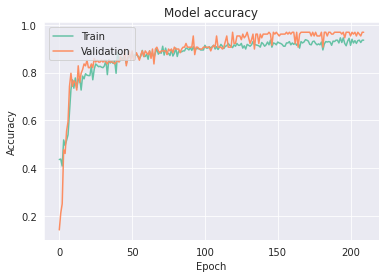

In [929]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

<hr>

- ### Visualization of Loss during training

<hr>

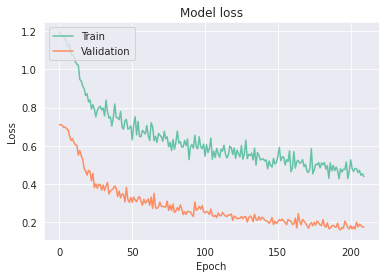

In [930]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

<hr>

- ### Evaluation with Classification Report 

Now it is time to use the additional test data and test how good is our model.

Note that we don’t use that data during the training, only once at the end of the process.

<hr>

In [931]:
#Round elements of the array to the nearest integer
y_pred = np.rint(model.predict(X_test))

# Model Accuracy, how often is the classifier correct?
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.96      0.97       138
           1       0.78      0.95      0.86        22

    accuracy                           0.96       160
   macro avg       0.89      0.96      0.92       160
weighted avg       0.96      0.96      0.96       160



<hr>

- ### Confusion Matrix

<hr>

<AxesSubplot:>

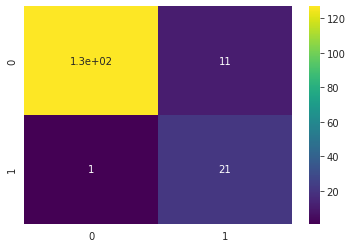

In [919]:
#Confusion matrix
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap='viridis')

<hr>

- ### Interactive Visualization on Testing Data

<hr>

In [905]:
actual = []
predcition = []
for i,j in zip(y_test,y_pred):
  actual.append(i)
  predcition.append(int(j))
dic = {'Actual':actual,
       'Prediction':predcition
       }
result  = pd.DataFrame(dic)


In [906]:


import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "iframe" 
fig = go.Figure()

 
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_test,
                    mode='markers+lines',
                    name='Test'))
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=result['Prediction'],
                    mode='markers',
                    name='Pred'))

<hr>

## Defining Column Transformers

We enumerate all columns that need feature scaling on deploying. 
<hr>

In [250]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
import joblib

transformer = make_column_transformer(
    (MinMaxScaler(), ['Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency'])
)

transformer.fit(X)


ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['Temperature', 'Pressure', 'VibrationX',
                                  'VibrationY', 'VibrationZ', 'Frequency'])])

<hr>

## Saving Model and Tranform for deploy
Now that we have a trained model, we need to store it and be able to reuse it later.

- The recommended approach of storing scikit-learn models and transforms is to use **joblib**.

- Saving the model architecture and weights of a **Keras** model is done with the save() method.

<hr>

In [ ]:
#Save the transformer using the dump method
joblib.dump(transformer, "minmax_scaler.joblib")
#Save the model using the save method from Keras in h5 format
model.save("Shape_prediction_model.h5")

<hr>

## Deploy of the Keras Neural Network on Web

A web application is developed using HTML and Flask web framework which is capable of predicting single point input and multiple inputs.

A REST API allows you to use your model to make predictions for different clients. Almost any device can speak REST - Android, iOS, Web browsers, and many others.

We are going to use **Flask** that allows us to  easily build a REST API as it´s fully supported by Python .

[Keras Model Deployed - Web App ](http://172.28.255.122:5000/)
<hr>